### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read GoF files to calculate p-value
2. Use GoF to show F-test results

env:bbVV


In [1]:
from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})


In [2]:
MAIN_DIR = "../../"

plot_dir = f"{MAIN_DIR}/plots/GoF_FTest/25Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

In [3]:
def p_value(data_ts: float, toy_ts: List[float]):
    return np.mean(toy_ts >= data_ts)


def F_statistic(
    ts_low: List[float],
    ts_high: List[float],
    ord_low: int,
    ord_high: int,
    num_bins: int = 20*6 ,# we have 20 bins per region, and 6 regions in total
    dim: int = 2, # number of polynomials to test
):
    numerator = (ts_low - ts_high) / (ord_high - ord_low)
    denominator = ts_high / (num_bins - (ord_high + dim))

    return numerator / denominator

### Quickly test all nTF p-value, according to the output, we prefer to further test (3,6) as final choice

In [8]:
nTF_a = "3"
nTF_b = "6"
local_cards_dir = "/ospool/cms-user/yuzhe/NanoNtupleChain/boostedHWW/combine/f_test/cards"
file_data = uproot.concatenate(
            f"{local_cards_dir}/nTFa_{nTFa}_nTFb_{nTFb}/higgsCombineData.GoodnessOfFit.mH125.root"
        )
data_ts = file_data["limit"][0]
# file_toys = uproot.concatenate(
#             f"{local_cards_dir}/nTFa_{nTFa}_nTFb_{nTFb}/higgsCombineToys{nTFa}{nTFb}.GoodnessOfFit.mH125.44*.root"
#         )
# toys_ts = np.array(file_toys["limit"])

In [9]:
data_ts

253.69987428188324

In [5]:
local_cards_dir = "/ospool/cms-user/yuzhe/NanoNtupleChain/boostedHWW/combine/f_test/cards"
for nTFa in range(3,4):
    for nTFb in range(5,6):
        file_toys = uproot.concatenate(
            f"{local_cards_dir}/nTFa_{nTFa}_nTFb_{nTFb}/higgsCombineToys{nTFa}{nTFb}.GoodnessOfFit.mH125.66*.root"
        )
        toys_ts = np.array(file_toys["limit"])
        file_data = uproot.concatenate(
            f"{local_cards_dir}/nTFa_{nTFa}_nTFb_{nTFb}/higgsCombineData.GoodnessOfFit.mH125.root"
        )
        data_ts = file_data["limit"][0]
        print(f"nTFa = {nTFa}, nTFb = {nTFb} ,p-value = ",p_value(data_ts,toys_ts))     

FileNotFoundError: file not found

    '/ospool/cms-user/yuzhe/NanoNtupleChain/boostedHWW/combine/f_test/cards/nTFa_3_nTFb_5/higgsCombineToys35.GoodnessOfFit.mH125.66*.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


### calculate F-test statistic

In [5]:
cards_dir = "/home/pku/zhaoyz/Higgs/boostedHWW/combine/f_test/cards/"
test_orders = [(3, 6)]
test_statistics = {}

for o1, o2 in test_orders:
    tdict = {"toys": {}, "data": {}, "ftoys": {}, "fdata": {}}
    tlabel = f"{o1}{o2}"

    for nTF1, nTF2 in [(o1, o2), (o1 + 1, o2), (o1, o2 + 1)]:
        # for nTF1, nTF2 in [(o1, o2)]:
        tflabel = f"{nTF1}{nTF2}"

        # test statistics for toys generated by (o1, o2) order model
        file = uproot.concatenate(
            f"{cards_dir}/nTFa_{nTF1}_nTFb_{nTF2}/higgsCombineToys{tlabel}Seed66.GoodnessOfFit.mH125.66.root"
        )
        tdict["toys"][tflabel] = np.array(file["limit"])

        # data test statistic
        file = uproot.concatenate(
            f"{cards_dir}/nTFa_{nTF1}_nTFb_{nTF2}/higgsCombineData.GoodnessOfFit.mH125.root"
        )
        tdict["data"][tflabel] = file["limit"][0]

        if not (nTF1 == o1 and nTF2 == o2):
            tdict["ftoys"][tflabel] = F_statistic(
                tdict["toys"][f"{o1}{o2}"], tdict["toys"][tflabel], o1 + o2, nTF1 + nTF2
            )
            tdict["fdata"][tflabel] = F_statistic(
                tdict["data"][f"{o1}{o2}"], tdict["data"][tflabel], o1 + o2, nTF1 + nTF2
            )
            #only if not (nTF1 == o1 and nTF2 == o2), we calculate the F-test statistic
            
    test_statistics[tlabel] = tdict

### define plot function

In [6]:
from scipy import stats

def plot_tests(
    data_ts: float,
    toy_ts: np.ndarray,
    name: str,
    title: str = None,
    bins: int = 15,
    fit: str = None,
    fdof2: int = None,
    order_value: str = None
):
    # plot_max = max(np.max(toy_ts), data_ts) #not enough
    # plot_max = 100
    plot_max = 20 if fit != "chi2" else 100
    # plot_min = min(np.min(toy_ts), data_ts, 0)
    plot_min = 0
    pval = p_value(data_ts, toy_ts)

    plt.figure(figsize=(12, 8))
    h = plt.hist(
        toy_ts,
        np.linspace(plot_min, plot_max, bins + 1),
        color="#8C8C8C",
        histtype="step",
        label=f"{len(toy_ts)} Toys",
    )
    plt.axvline(data_ts, color="#FF502E", linestyle=":", label=rf"Data ($p$-value = {pval:.2f})")

    if fit is not None:
        x = np.linspace(plot_min + 0.01, plot_max, 100)

        if fit == "chi2":
            res = stats.fit(stats.chi2, toy_ts, [(0, 200)])
            pdf = stats.chi2.pdf(x, res.params.df)
            label = rf"$\chi^2_{{DoF = {res.params.df:.2f}}}$ Fit"
        elif fit == "f":
            pdf = stats.f.pdf(x, 1, fdof2)
            label = rf"$F-dist_{{DoF = (1, {fdof2})}}$"
        else:
            raise ValueError("Invalid fit")

        plt.plot(
            x,
            pdf * (np.max(h[0]) / np.max(pdf)),
            color="#1f78b4",
            linestyle="--",
            # alpha=0.6,
            label=label,
        )

    hep.cms.label(
        "Work in Progress",
        data=True,
        lumi=138,
        year=None,
    )

    _ = plt.legend()
    plt.title(title)
    plt.ylabel("Number of Toys")
    plt.xlabel(f"Test Statistics") #need to be modified for F test value

    plt.savefig(f"{plot_dir}/{name}.pdf", bbox_inches="tight")

### plot GoF and F-test results

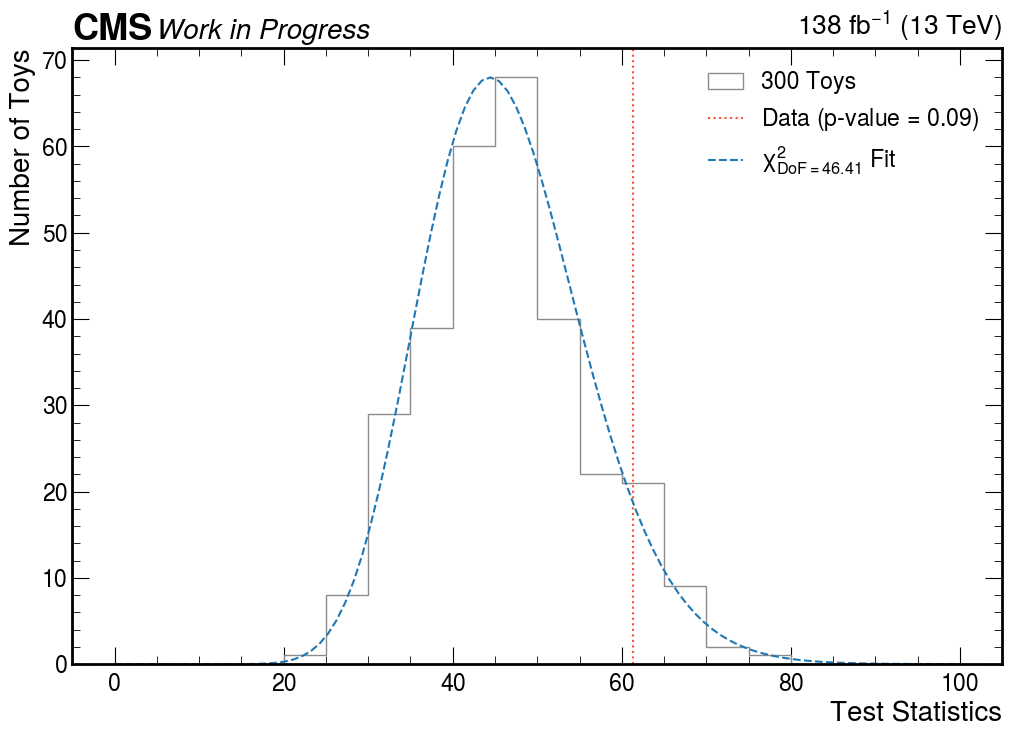

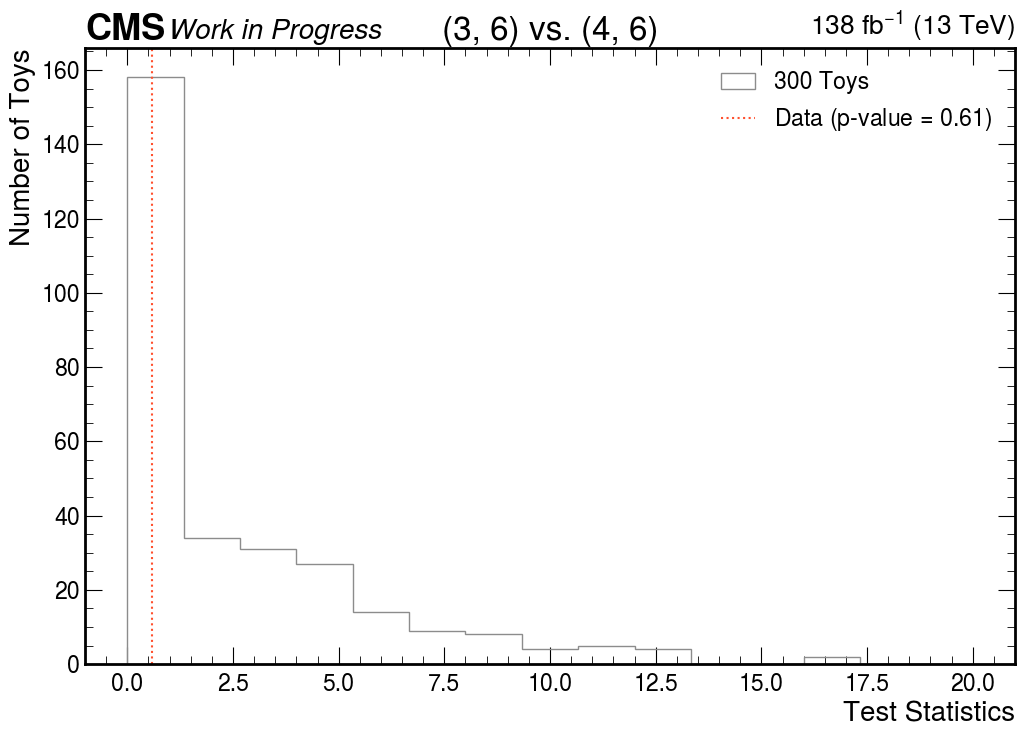

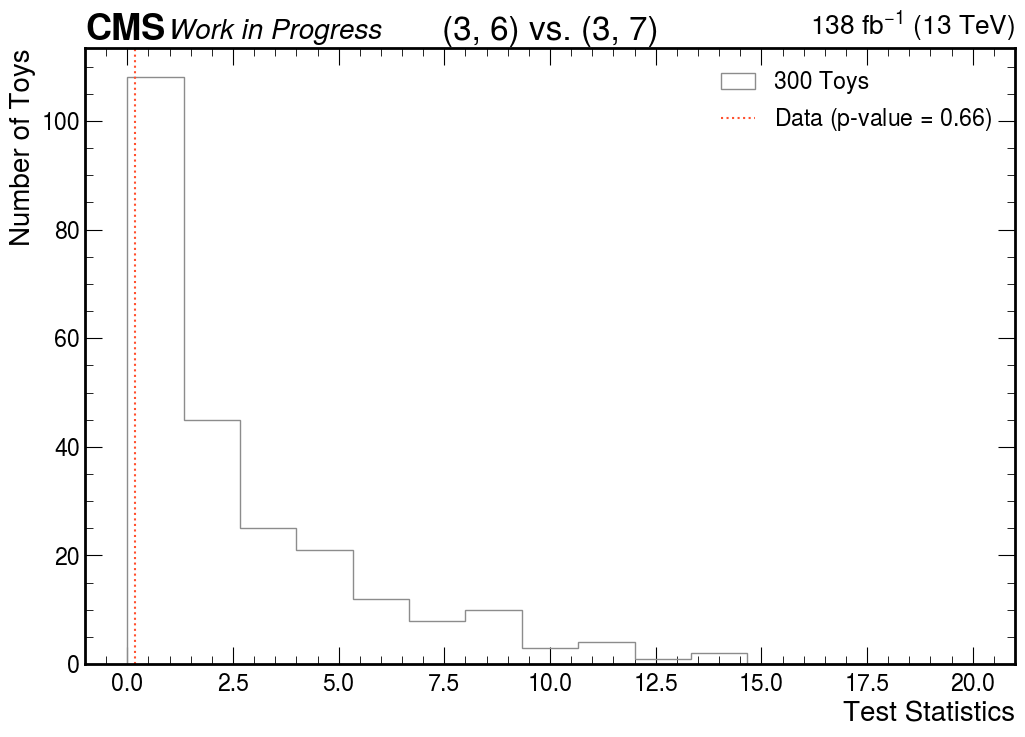

In [7]:
o1, o2 = 3, 6  # order being tested
tlabel = f"{o1}{o2}"

data_ts, toy_ts = test_statistics[tlabel]["data"][tlabel], test_statistics[tlabel]["toys"][tlabel]
plot_tests(data_ts, toy_ts, "gof" + tlabel, fit="chi2", bins=20)

for ord1, ord2 in [[o1 + 1, o2], [o1, o2 + 1]]:
    tflabel = f"{ord1}{ord2}"
    data_ts, toy_ts = pval = (
        test_statistics[tlabel]["fdata"][tflabel],
        test_statistics[tlabel]["ftoys"][tflabel],
    )
    plot_tests(data_ts, toy_ts, f"f{tlabel}_{tflabel}", title=f"({o1}, {o2}) vs. ({ord1}, {ord2})")